#### Importing all libraries

In [1]:
import pandas as PD
import seaborn as SNS
import matplotlib.pyplot as PLT
import numpy as NP
from numpy import sum

In [2]:
custom_colours = ['#74a09e','#98e2c6','#f2a553','#c14953']
SNS.set_theme(style="whitegrid",palette=custom_colours)

#### Loading the dataset

In [3]:
raw_data = PD.read_csv("50_Startups.csv", sep=";")
data = raw_data.copy()

#### Initial data exploration

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   R&D             50 non-null     float64
 1   Administration  50 non-null     float64
 2   Marketing       50 non-null     float64
 3   villes          50 non-null     object 
 4   Profit          50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


This dataset has **50** entries in **5** columns. It has **no missing data**. **4** columns are **numerical** and **1** column is **categorical**.

In [5]:
data.head()

,R&D,Administration,Marketing,villes,Profit
0,165349.20,136897.80,471784.10,Paris,192261.83
1,162597.70,151377.59,443898.53,Strasbourg,191792.06
2,153441.51,101145.55,407934.54,Lyon,191050.39
3,144372.41,118671.85,383199.62,Paris,182901.99
4,142107.34,91391.77,366168.42,Lyon,166187.94


Columns are ordered as follows:
- **3** columns detailing the **budget** each startup grants to each of their departments: **R&D**, **Administration** and **Marketing**.
- **1** column detailing the **location** where the startup supposedly operates from.
- **1** column detailing the **profit** each startup has made over an **unknown timespan**.

Paris         17
Strasbourg    17
Lyon          16
Name: villes, dtype: int64


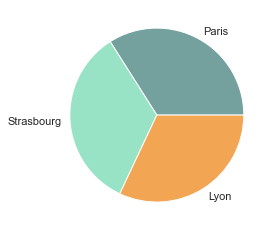

In [6]:
print(data["villes"].value_counts())
PLT.pie(data["villes"].value_counts(),labels=data["villes"].unique())
PLT.show()

We see here that we can order the dataset by the **'villes'** column since it is balanced around those values, with an even spread between all three of the cities found in that column : **Strasbourg**, **Paris** and **Lyon**.

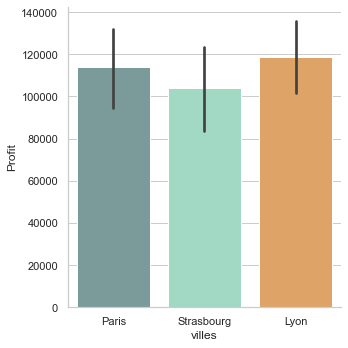

In [7]:
SNS.catplot(data=data,kind="bar",x="villes",y="Profit")
PLT.show()

We can see from this graph that, at face value, the "best" city to operate from is **Lyon** since it boasts both the highest **average profit** and **maximum profit**.

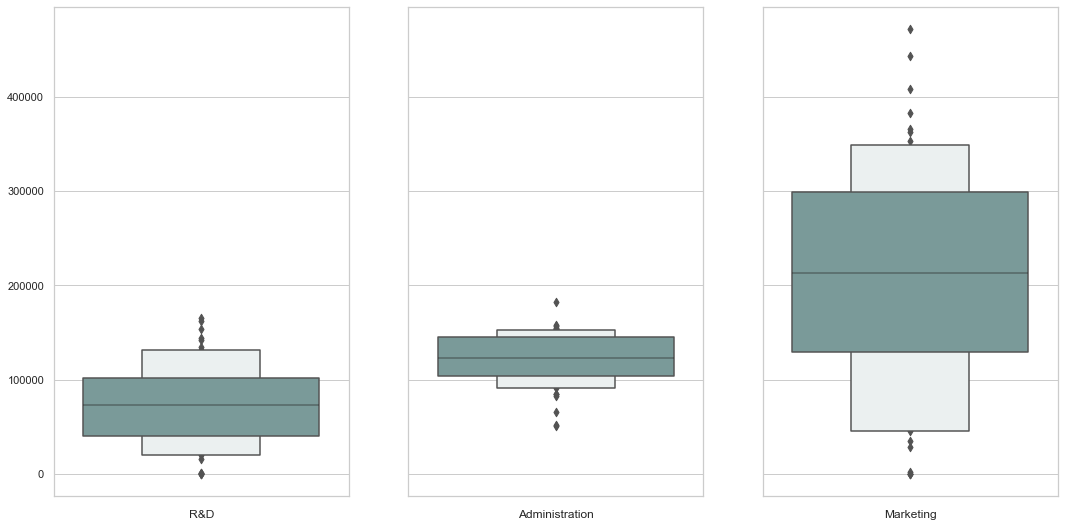

In [8]:
fig, ax = PLT.subplots(1,3,figsize=(18,9),sharey=True)
SNS.boxenplot(data=data,y="R&D",ax=ax[0])
ax[0].set_xlabel("R&D")
ax[0].set_ylabel("")
SNS.boxenplot(data=data,y="Administration",ax=ax[1])
ax[1].set_xlabel("Administration")
ax[1].set_ylabel("")
SNS.boxenplot(data=data,y="Marketing",ax=ax[2])
ax[2].set_xlabel("Marketing")
ax[2].set_ylabel("")
PLT.show()

By far, the highest budget allocation goes to the marketing department, it also demonstrates that there is a large variety of investment strategies for marketing whereas the budget for administration seems to have been figured out by most, as if they all shared a similar template; the same cannot be said for R&D but its overall budget remains the lowest across the board.

In [9]:
data.corr()

,R&D,Administration,Marketing,Profit
R&D,1.000000,0.241955,0.724248,0.972900
Administration,0.241955,1.000000,-0.032154,0.200717
Marketing,0.724248,-0.032154,1.000000,0.747766
Profit,0.972900,0.200717,0.747766,1.000000


At first glance, we can see a strong correlation between R&D and Profit, a significant correlation between Marketing and Profit and almost none between Administration and Profit. This is not unexpected since the administration department cannot be expected to have as direct an impact on profit.

#### Plotting for each correlation

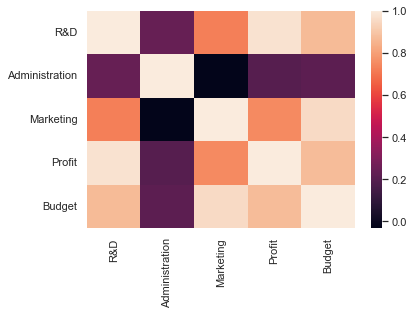

In [51]:
SNS.heatmap(data.corr())
PLT.show()

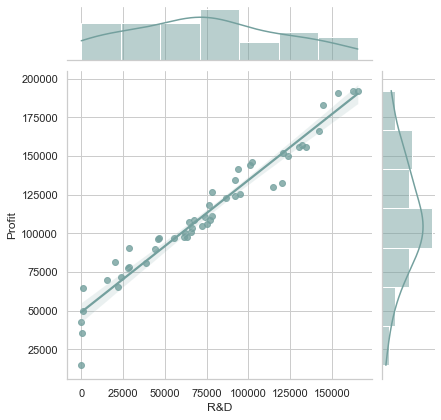

In [10]:
SNS.jointplot(x="R&D",y="Profit",kind="reg",data=data)
PLT.show()

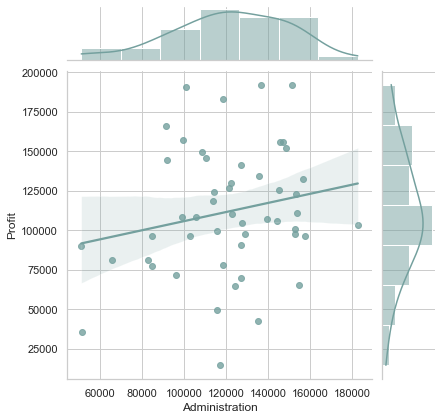

In [11]:
SNS.jointplot(x="Administration",y="Profit",kind="reg",data=data)
PLT.show()

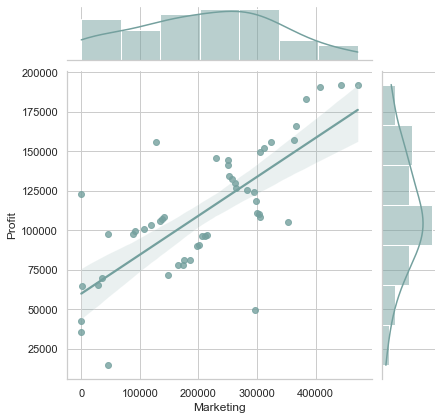

In [12]:
SNS.jointplot(x="Marketing",y="Profit",kind="reg",data=data)
PLT.show()

In [13]:
data["Budget"] = data["R&D"]+data["Administration"]+data["Marketing"]
data.head()

,R&D,Administration,Marketing,villes,Profit,Budget
0,165349.20,136897.80,471784.10,Paris,192261.83,774031.10
1,162597.70,151377.59,443898.53,Strasbourg,191792.06,757873.82
2,153441.51,101145.55,407934.54,Lyon,191050.39,662521.60
3,144372.41,118671.85,383199.62,Paris,182901.99,646243.88
4,142107.34,91391.77,366168.42,Lyon,166187.94,599667.53


We decide to sum up all bugdets together in a new 'Budget' column to see the correlation between the overall budget of a startup and their profit. We expect a loss in precision in our model.

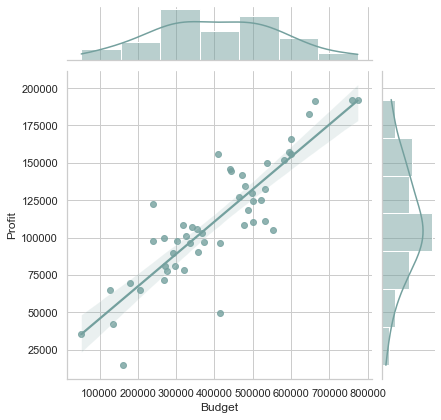

In [14]:
SNS.jointplot(x="Budget",y="Profit",kind="reg",data=data)
PLT.show()

Expectedly, the idea that you need to 'spend money to make money' seems to be holding true, with an almost normal distribution of our values.

##### Linear Regression Model(s)

Importing all machine learning libraries

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, r2_score, max_error, mean_squared_error

Choosing our features and target

In [16]:
LR = LinearRegression()
X = data.loc[:,data.columns != 'Profit'].copy()
X.drop("villes",axis=1,inplace=True)
y = data['Profit'].copy()

We have decided not to encode and use the "villes" feature because we don't see any strong correlations.

Creating the training and testing datasets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=666)

Reinventing the wheel

In [18]:
def R2_AdjR2(y,f,nb_features):
    p = nb_features
    n = len(y)
    SSres = 0
    for i in range(n):
        ei = y[i] - f[i]
        SSres += ei**2
    y_ = (1/n)*sum(y)
    SStot = 0
    for i in range(n):
        SStot += (y[i]-y_)**2
    R2 = 1 - (SSres/SStot)
    dfe = n-p-1
    dft = n-1
    adj_R2 = 1 - (SSres/dfe)/(SStot/dft) # adj_R2 = 1 - (1-R2)*(n-1)/(n-p-1)
    return R2, adj_R2

Training and scoring the Linear Regression model

In [69]:
LR.fit(X_train,y_train)
predictions = LR.predict(X_test)
res_df = PD.DataFrame(dict(R_et_D=X_test["R&D"],Administration=X_test['Administration'],Marketing=X_test['Marketing'], Budget=X_test['Budget'],y_true=y_test,y_pred=predictions))
Y = NP.array(y_test)
f = NP.array(predictions)
R2, adj_R2 = R2_AdjR2(Y,f,LR.n_features_in_)
print(f"R²:\n{R2}\n")
print(f"Adjusted R²:\n{adj_R2}\n")
print(f"Explained Variance Score:\n{explained_variance_score(y_test,predictions)}\n")
print(f"Coefficients:\n{LR.coef_}")

R²:
0.9276077903491879

Adjusted R²:
0.8986509064888631

Explained Variance Score:
0.9304308321988444

Coefficients:
[-1.63157713e+12 -1.63157713e+12 -1.63157713e+12  1.63157713e+12]


Comparing our predictions, for each feature, with the true values *(pink is prediction, green is true)*

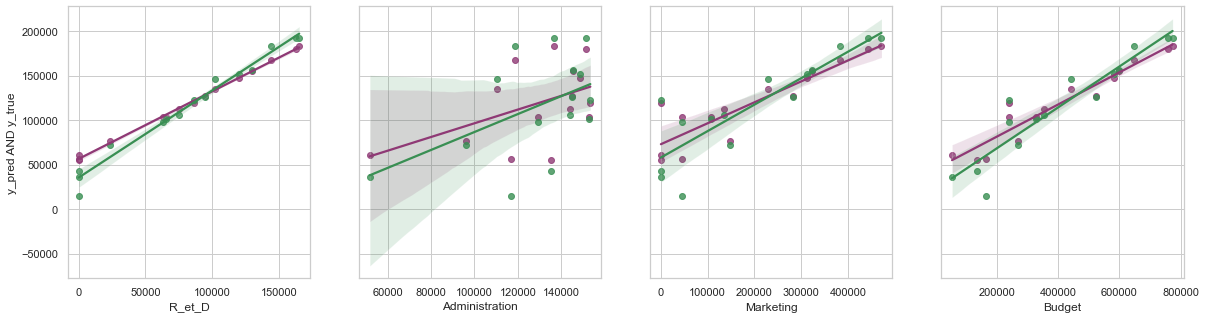

In [27]:
fig, ax = PLT.subplots(1,4,figsize=(20,5), sharey=True)
SNS.regplot(x="R_et_D",y="y_pred",data=res_df, ax=ax[0], color="#8F3975")
SNS.regplot(x="R_et_D",y="y_true",data=res_df, ax=ax[0], color="#398F53")
ax[0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Administration",y="y_pred",data=res_df, ax=ax[1], color="#8F3975")
SNS.regplot(x="Administration",y="y_true",data=res_df, ax=ax[1], color="#398F53")
ax[1].set_ylabel("")

SNS.regplot(x="Marketing",y="y_pred",data=res_df, ax=ax[2], color="#8F3975")
SNS.regplot(x="Marketing",y="y_true",data=res_df, ax=ax[2], color="#398F53")
ax[2].set_ylabel("")

SNS.regplot(x="Budget",y="y_pred",data=res_df, ax=ax[3], color="#8F3975")
SNS.regplot(x="Budget",y="y_true",data=res_df, ax=ax[3], color="#398F53")
ax[3].set_ylabel("")
PLT.show()

These graphs show that the 'Administration' feature could be introducing some bias. We will confirm our intuition with F-ANOVA.

In [21]:
from sklearn.feature_selection import f_regression
f_statistic, p_values = f_regression(X,y)
print(f"F values = {f_statistic}")
print(f"P values = {p_values}")

F values = [849.7889044    2.01495972  60.88145448 153.19616857]
P values = [3.50032224e-32 1.62217395e-01 4.38107318e-10 1.50826749e-16]


Training and scoring the Linear Regression model with the new set of features

In [70]:
LR_A = LinearRegression()
Xa = X.drop(columns=["Administration"])
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa,y,test_size=.3,random_state=666)
LR_A.fit(Xa_train,ya_train)
A_predictions = LR_A.predict(Xa_test)
Y = NP.array(ya_test)
f = NP.array(A_predictions)
R2, adj_R2 = R2_AdjR2(Y,f,LR_A.n_features_in_)
print(f"R²:\n{R2}\n")
print(f"Adjusted R²:\n{adj_R2}\n")
print(f"Explained Variance Score:\n{explained_variance_score(ya_test,A_predictions)}\n")
print(f"Coefficients:\n{LR_A.coef_}")

R²:
0.9276164775194324

Adjusted R²:
0.907875516842914

Explained Variance Score:
0.9304730465291712

Coefficients:
[ 0.8243257   0.07337703 -0.06678468]


When compared with the previous **adjusted R² score** *(0.8986509064888631)* we see an improvement of .0014, or 1 whole percent when rounded quite generously.


Comparing our predictions, for each feature, with the true values *(pink is prediction, green is true)*

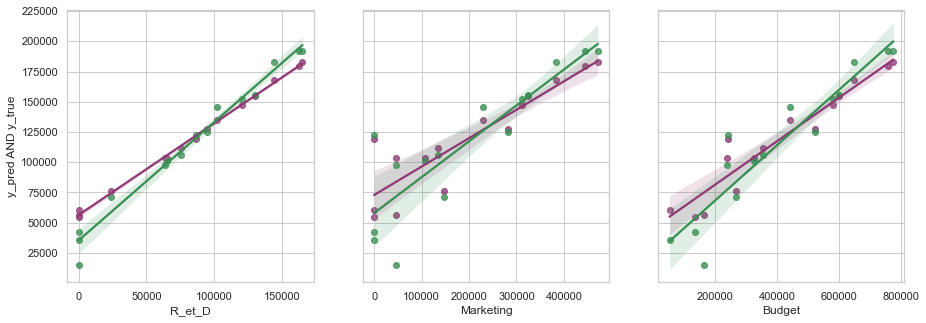

In [28]:
res_df_A = PD.DataFrame(dict(R_et_D=Xa_test["R&D"],Marketing=Xa_test['Marketing'], Budget=Xa_test['Budget'],y_true=ya_test,y_pred=A_predictions))
fig, ax = PLT.subplots(1,3,figsize=(15,5), sharey=True)
SNS.regplot(x="R_et_D",y="y_pred",data=res_df_A, ax=ax[0], color="#8F3975")
SNS.regplot(x="R_et_D",y="y_true",data=res_df_A, ax=ax[0], color="#398F53")
ax[0].set_ylabel("y_pred AND y_true")

SNS.regplot(x="Marketing",y="y_pred",data=res_df_A, ax=ax[1], color="#8F3975")
SNS.regplot(x="Marketing",y="y_true",data=res_df_A, ax=ax[1], color="#398F53")
ax[1].set_ylabel("")

SNS.regplot(x="Budget",y="y_pred",data=res_df_A, ax=ax[2], color="#8F3975")
SNS.regplot(x="Budget",y="y_true",data=res_df_A, ax=ax[2], color="#398F53") 
ax[2].set_ylabel("")

PLT.show()

The new model is **objectively** better, thus we'll pick it for the prediction.

In [46]:
R_n_D_budget = 99666
Marketing_budget = 242069
Budget_budget = R_n_D_budget + Marketing_budget

big_dict = {"R&D":R_n_D_budget,"Marketing":Marketing_budget,"Budget":Budget_budget}
x_try = PD.DataFrame(big_dict, index=[0])
x_try.head()

,R&D,Marketing,Budget
0,99666,242069,341735


In [47]:
try_predict = LR_A.predict(x_try)
print(try_predict)

[140850.82515463]


### Rapport

- **Nom:** Victorino, Thiberino
- **Date:** Oui.
- **Cible client:** Non. 

**Contexte:**
> "La BPI France dispose d'un fond d'investissement qu'elle voudrait utiliser pour investir dans les start'up de demain les plus
prometteuses. Seulement elle ne sait pas comment les sélectionner. 
Faut-il investir dans celles qui dépensent le plus en marketing? en recherche et développement? dans quelles villes les startups semblent mieux opérer? Elle fait donc appel à vous pour y voir plus clair..."

**Objectif:**
> "Vous devez donc concevoir un modèle de régression linéaire multiple qui permettra à la BPI d'une part de sélectionner les 5
start'up les plus prometteuses et d'autre part de déterminer dans quel(s) secteur(s) il serait le plus judicieux de répartir les
budgets de dépenses."

*Faut -il investir dans les entreprises qui dépensent le plus en marketing ou en recherche et développement?*

In [66]:
data_1 = data.copy()
data_1.drop("Administration",axis=1,inplace=True)
data_1.drop("villes",axis=1,inplace=True)
data_1.drop("Budget",axis=1,inplace=True)
data_1.sort_values(by="Profit",ascending=False)
print(f"Max Marketing:\n{data_1['Marketing'].max()}")
print(f"Max R&D:\n{data_1['R&D'].max()}")
data_1.head()

Max Marketing:
471784.1
Max R&D:
165349.2


,R&D,Marketing,Profit
0,165349.20,471784.10,192261.83
1,162597.70,443898.53,191792.06
2,153441.51,407934.54,191050.39
3,144372.41,383199.62,182901.99
4,142107.34,366168.42,166187.94


Au vu de la forte correlation entre ces deux features, investir dans l'un ou l'autre ménera à l'augmentation des profits.

*Dans quelles villes les startups semblent elles mieux opérer?*

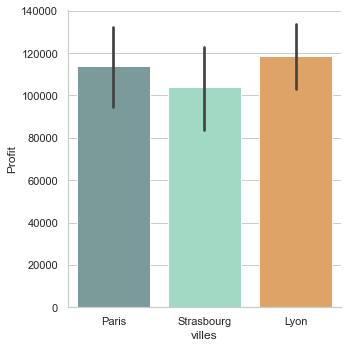

In [67]:
SNS.catplot(data=data,kind="bar",x="villes",y="Profit")
PLT.show()

Lyon est plus profitable que Paris qui est plus profitable que Strasbourg.


- *Est-ce les coefficients directeurs de la regression linéaire multiple apparaissent? Sont-ils interprétés?*
    - Oui et non.

- *Est-ce que le rapport se termine sur une conclusion claire?*
    - Non.

En conclusion, 